# Training and Deployment of classification of dog images
- This notebook defines the pipeline for training and deploying a model to classify dog breeds in images using AWS SageMaker. 
- The model is based on the ResNet50 model and adds a classifier fully connected neural network to the end of the model. This model is fine tuned to improve accuracy.  
- Hyperparameter searches yield the hyperparameters with the best classification accuracy. 
- Profiling is used to help debug the training job.
- Model is then deployed and its accuracy is tested with randomly selected test images.

## Package installation

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
# Install AWS CLI to download file
!pip install awscli

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [2]:
# package loading
import sagemaker
import boto3
import os
import pandas as pd
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule, 
    rule_configs,
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile,
)
from sagemaker.pytorch import PyTorch
from sagemaker.predictor import Predictor
import random

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Load Dataset
Dataset is the dog classification dataset available at ... 
It contains 133 classes of images of different dog breeds. 

In [3]:
# Use AWS CLI to download the file
!aws s3 cp s3://jm-dog-project-bucket/dogImages.zip . --region us-east-1
!unzip dogImages.zip


  Using cached awscli-1.35.20-py3-none-any.whl.metadata (11 kB)
  Using cached botocore-1.35.54-py3-none-any.whl.metadata (5.7 kB)
  Using cached docutils-0.16-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached rsa-4.7.2-py3-none-any.whl.metadata (3.6 kB)
Using cached awscli-1.35.20-py3-none-any.whl (4.5 MB)
Using cached botocore-1.35.54-py3-none-any.whl (12.7 MB)
Using cached docutils-0.16-py2.py3-none-any.whl (548 kB)
Using cached rsa-4.7.2-py3-none-any.whl (34 kB)
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.162
    Uninstalling botocore-1.34.162:
      Successfully uninstalled botocore-1.34.162
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.3 requires botocore<1.34.163,>

In [3]:
# explore dataset
list_of_test_classes = os.listdir('./dogImages/test')
list_of_train_classes = os.listdir('./dogImages/train')
list_of_validate_classes = os.listdir('./dogImages/valid')

number_of_test_classes = len(list_of_test_classes)
number_of_train_classes = len(list_of_train_classes)
number_of_validate_classes = len(list_of_validate_classes)

print(f'Number of train classes: {number_of_train_classes}, number of test classes: {number_of_test_classes}, number of validate classes: {list_of_validate_classes}')

Number of train classes: 133, number of test classes: 133


## Hyperparameter Tuning
Hyperparameters chosen to tune: 
- lr as in range 0.001 to 0.1. Tested as this is a reasonable range to test without having too severe a learning rate. Optimal value: 0.0014611377532535268
- batch-size between 32, 64, 128. Range of values as balance between accuracy and speed. Optimal value: 64 
- epochs between 2 and 4. Balance again between accuracy and speed. Optimal value: 3



In [7]:
# defining essentials for sagemaker 
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/ml-udacity-project"

role = sagemaker.get_execution_role()

In [8]:
# checking if data already in s3 bucket
s3 = boto3.client('s3')

def check_s3_path_exists(bucket, prefix):
    response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    return 'Contents' in response

if check_s3_path_exists(bucket, prefix):
    print("Data already exists in S3, no need to upload.")
    inputs = f"s3://{bucket}/{prefix}"
else:
    print("Data not found in S3, proceeding with upload.")
    inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

print("Inputs defined as:", inputs)


Data already exists in S3, no need to upload.
Inputs defined as: s3://sagemaker-us-east-1-846247097515/sagemaker/ml-udacity-project


In [ ]:
# for testing the hpo.py script
#! python3 hpo.py --batch-size 64 --epochs 2 --lr 0.01 --data-path "./dogImages/" 

In [34]:
#Declare  HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": IntegerParameter(2, 4)
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [35]:
#Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name = 'dog-breed-classification',
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [37]:
# Fit your HP Tuner
tuner.fit(inputs, wait = True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [38]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-11-11 12:27:33 Starting - Preparing the instances for training
2024-11-11 12:27:33 Downloading - Downloading the training image
2024-11-11 12:27:33 Training - Training image download completed. Training in progress.
2024-11-11 12:27:33 Uploading - Uploading generated training model
2024-11-11 12:27:33 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"64"',
 'epochs': '3',
 'lr': '0.0014611377532535268',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-2024-11-11-11-02-46-302"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-846247097515/dog-breed-classification-2024-11-11-11-02-46-302/source/sourcedir.tar.gz"'}

In [41]:
tuner.best_training_job()

'pytorch-training-241111-1102-001-d659947b'

## Model Profiling and Debugging
Optimal Hyperparameter values: 
- lr = 0.0014611377532535268
- batch-size = 64 
- epochs = 3


Use these to run an individual training job that can be deployed as an endpoint. Debugging and profiling included to help smooth the process. 


In [39]:
# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

training_job_name = 'pytorch-training-241111-1102-001-d659947b'
best_training_job_details = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)


In [40]:
hyperparameters = best_training_job_details['HyperParameters']
role = best_training_job_details['RoleArn']
image_uri = best_training_job_details['AlgorithmSpecification']['TrainingImage']
output_path = best_training_job_details['OutputDataConfig']['S3OutputPath']


In [42]:
for key, value in hyperparameters.items():
    print(key, value)

_tuning_objective_metric Test Loss
batch-size "64"
epochs 3
lr 0.0014611377532535268
sagemaker_container_log_level 20
sagemaker_estimator_class_name "PyTorch"
sagemaker_estimator_module "sagemaker.pytorch.estimator"
sagemaker_job_name "dog-breed-classification-2024-11-11-11-02-46-302"
sagemaker_program "hpo.py"
sagemaker_region "us-east-1"
sagemaker_submit_directory "s3://sagemaker-us-east-1-846247097515/dog-breed-classification-2024-11-11-11-02-46-302/source/sourcedir.tar.gz"


In [127]:
# redefined here to prevent issues in variable types
best_hyperparameters = {
    'batch-size': 64,
     'epochs': 3,
     'lr': 0.0014611377532535268,
}

In [170]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params = FrameworkProfile(num_steps=10)
)
#instead of hook, because I couldnt get the hook to work...
collection_config = [
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", # best for image classification with multiple classes
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]

debugger_config = DebuggerHookConfig(collection_configs = collection_config)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [129]:
# check train_model.py with hyperparameters 
#!python3 train_model.py --batch-size 64 --epochs 3 --lr 0.0014611377532535268 --data-path './dogImages'

In [171]:
#Create  estimator


estimator = PyTorch(
    entry_point = 'train_model_3.py',
    role = role,
    instance_count=1,
    instance_type = 'ml.p2.xlarge', #changed cos kept crahsing 
    py_version = 'py36',
    framework_version = '1.6',
    hyperparameters = best_hyperparameters,
    profiler_config = profiler_config, 
    debugger_hook_config = debugger_config, 
    rules = rules 
) 



In [172]:
# fit
estimator.fit(inputs, wait = True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving i

2024-11-13 13:13:45 Starting - Starting the training job...
2024-11-13 13:14:14 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2024-11-13 13:15:14 Downloading - Downloading input data......
2024-11-13 13:16:15 Downloading - Downloading the training image............
2024-11-13 13:18:15 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-11-13 13:18:21,783 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-11-13 13:18:21,808 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-11-13 13:18:21,810 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-11-13 13:18:22,068 sagemaker-training-toolkit INFO  

In [173]:
# Plot a debugging output.
job_name = estimator._current_job_name
print('Job name:', job_name)


Job name: pytorch-training-2024-11-13-13-13-38-876


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [174]:
# define and check the path to rule report 
path_for_report = os.path.join('s3://', bucket, job_name, 'rule-output')
print(f'Profiler report location: {path_for_report}')

Profiler report location: s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-13-13-13-38-876/rule-output


In [175]:
# print files in relevant folder
!aws s3 ls "$path_for_report" --recursive

2024-11-13 13:25:26     418554 pytorch-training-2024-11-13-13-13-38-876/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-11-13 13:25:26     274370 pytorch-training-2024-11-13-13-13-38-876/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-11-13 13:25:21        192 pytorch-training-2024-11-13-13-13-38-876/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-11-13 13:25:21      13895 pytorch-training-2024-11-13-13-13-38-876/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-11-13 13:25:21        126 pytorch-training-2024-11-13-13-13-38-876/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-11-13 13:25:21        339 pytorch-training-2024-11-13-13-13-38-876/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-11-13 13:25:21       2176 pytorch-training-2024-11-13-13-13-38-876/rule-output/ProfilerReport/profiler-output/profiler-re

In [176]:
#collect files in relevant folder 
!aws s3 cp "$path_for_report" . --recursive

download: s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-13-13-13-38-876/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-13-13-13-38-876/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-13-13-13-38-876/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-13-13-13-38-876/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-846247097515/pytorc

In [177]:
#display the debugging report
import IPython

IPython.display.HTML(filename= './ProfilerReport/profiler-output/profiler-report.html')

## Model Deploying

In [66]:
# Define the root directory containing the image subdirectories
root_dir = './dogImages/test'

# Collect all image file paths in a list
all_image_paths = []
for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        # Check if the file is an image (e.g., .jpg, .png)
        if file.lower().endswith(('.jpg')):
            all_image_paths.append(os.path.join(dirpath, file))

# Select 10 random images
random_images = random.sample(all_image_paths, 10)

# Display the selected random image paths
print(random_images)


['./dogImages/test/013.Australian_terrier/Australian_terrier_00897.jpg', './dogImages/test/042.Cairn_terrier/Cairn_terrier_02979.jpg', './dogImages/test/002.Afghan_hound/Afghan_hound_00146.jpg', './dogImages/test/070.German_pinscher/German_pinscher_04863.jpg', './dogImages/test/071.German_shepherd_dog/German_shepherd_dog_04961.jpg', './dogImages/test/016.Beagle/Beagle_01197.jpg', './dogImages/test/023.Bernese_mountain_dog/Bernese_mountain_dog_01638.jpg', './dogImages/test/026.Black_russian_terrier/Black_russian_terrier_01837.jpg', './dogImages/test/056.Dachshund/Dachshund_03995.jpg', './dogImages/test/020.Belgian_malinois/Belgian_malinois_01472.jpg']


In [178]:
# helper class that facilitates the processing of byte arrays
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class DogImage(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(DogImage, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [212]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-13-13-13-38-876/output/model.tar.gz


In [208]:
# define pytorch model
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='endpoint_setup.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=DogImage)

In [209]:
# Add your deployment configuration like instance type and number of instances
predictor=estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
) 

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-13-13-13-38-876/output/model.tar.gz), script artifact (s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-13-13-13-38-876/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-13-14-12-59-762/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-training-2024-11-13-14-12-59-762
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2024-11-13-14-12-59-762
INFO:sagemaker:Creating endpoint with name pytorch-training-2024-11-13-14-12-59-762


-------!

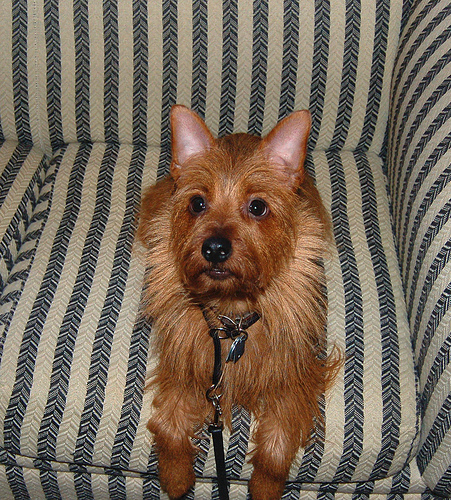

In [213]:
# select byte imagefrom PIL import Image
import io
with open(random_images[0], "rb") as image:
    img_bytes = image.read()

Image.open(io.BytesIO(img_bytes))

In [210]:
# Deploy your model to an endpoint
response = predictor.predict(
    img_bytes,
    initial_args={
        "ContentType": "image/jpeg"
    }
)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary and could not load the entire response body. See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-2024-11-13-14-12-59-762 in account 846247097515 for more information.

In [ ]:
predictor.delete_endpoint()

## testing endpoint_setup outside of AWS function

In [198]:
# Define the model loading function
MODEL_PATH = "model.pt"
print("Loading model...")
model = torch.jit.load(MODEL_PATH, map_location=device)
model.eval()
print("Model loaded and ready for inference.")

Loading model...
Model loaded and ready for inference.


In [201]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import json
import io

MODEL_PATH = "model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def model_fn(model_dir):
    print("Loading model...")
    model = torch.jit.load(model_dir, map_location=device)
    model.eval()
    print("Model loaded and ready for inference.")
    return model


def input_fn(request_body, request_content_type):
    print("Processing input data...")
    if request_content_type == "application/json":
        data = json.loads(request_body)
        data = torch.tensor(data, dtype=torch.float32).to(device)
    elif request_content_type in ["image/jpeg", "image/jpg"]:
        data = Image.open(io.BytesIO(request_body))
    else:
        raise ValueError(f"Unsupported content type: {request_content_type}")
    return data


def predict_fn(input_object, model):
    print("Running inference...")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    input_object = transform(input_object).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(input_object)
    return prediction


def output_fn(predictions, content_type="application/json"):
    if content_type == "application/json":
        return json.dumps(predictions.cpu().numpy().tolist())
    else:
        raise ValueError(f"Unsupported content type: {content_type}")

# Load the model
model = model_fn(MODEL_PATH)


def test_with_image(image_path):
    # Load and prepare the image
    with open(image_path, "rb") as f:
        image_bytes = f.read()
    input_data = input_fn(image_bytes, "image/jpeg")
    
    # Run prediction
    prediction = predict_fn(input_data, model)
    
    # Format output
    result = output_fn(prediction)
    print("Prediction:", result)

# Run the test
test_with_image(random_images[0])  


Loading model...
Model loaded and ready for inference.
Processing input data...
Running inference...
Prediction: [[-20.370216369628906, -20.60591697692871, -18.023292541503906, -21.67742347717285, -27.739866256713867, -20.807701110839844, -23.00066375732422, -22.966278076171875, -19.083030700683594, -28.612667083740234, -13.63871955871582, -18.137985229492188, -0.14693008363246918, -11.742705345153809, -21.345949172973633, -20.084245681762695, -23.577625274658203, -18.868703842163086, -21.654685974121094, -17.595428466796875, -22.06080436706543, -17.483823776245117, -28.183008193969727, -20.644874572753906, -23.259647369384766, -32.09975814819336, -21.646392822265625, -23.74658966064453, -22.594900131225586, -17.82358741760254, -26.552907943725586, -18.350112915039062, -28.56489372253418, -21.817855834960938, -20.341861724853516, -17.8133487701416, -18.069692611694336, -11.91807746887207, -15.256560325622559, -22.35289764404297, -27.16022491455078, -12.965027809143066, -16.353214263916